In [1]:
import torch
import numpy as np
import pandas as pd
import kagglehub
import os
import cv2
import random

from glob import glob
from matplotlib import pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm


In [2]:
!pip -q install kagglehub[pandas-datasets]
print("📥 Téléchargement du dataset...")
dataset_path = kagglehub.dataset_download("shafiullahshafin/c-nmc-2019-dataset")

print(f"✅ Dataset téléchargé ici : {dataset_path}")

def build_dataframe(base_path):
    data = []
    image_paths = glob(os.path.join(base_path, '**', '*.bmp'), recursive=True)

    print(f"🔍 Images trouvées : {len(image_paths)}")

    for img_path in image_paths:
        folder_name = os.path.basename(os.path.dirname(img_path))

        if 'all' in folder_name.lower():
            label = 'ALL'
        elif 'hem' in folder_name.lower():
            label = 'HEM' # Normal
        else:
            continue

        data.append({
            'image_path': img_path,
            'label': label,
            'filename': os.path.basename(img_path)
        })

    return pd.DataFrame(data)

df = build_dataframe(dataset_path)

print(f"\n📊 DataFrame construit avec {len(df)} images.")
print(df.head())

📥 Téléchargement du dataset...


100%|██████████| 868M/868M [00:42<00:00, 21.5MB/s]

Extracting files...


✅ Dataset téléchargé ici : /root/.cache/kagglehub/datasets/shafiullahshafin/c-nmc-2019-dataset/versions/1
🔍 Images trouvées : 15114

📊 DataFrame construit avec 10661 images.
                                          image_path label  \
0  /root/.cache/kagglehub/datasets/shafiullahshaf...   ALL   
1  /root/.cache/kagglehub/datasets/shafiullahshaf...   ALL   
2  /root/.cache/kagglehub/datasets/shafiullahshaf...   ALL   
3  /root/.cache/kagglehub/datasets/shafiullahshaf...   ALL   
4  /root/.cache/kagglehub/datasets/shafiullahshaf...   ALL   

              filename  
0  UID_68_37_2_all.bmp  
1  UID_24_16_3_all.bmp  
2  UID_49_12_5_all.bmp  
3  UID_75_33_2_all.bmp  
4   UID_25_4_7_all.bmp  


## Baseline ResNet



### Dataset

In [3]:
from dataclasses import dataclass

@dataclass
class Config:
  seed: int = 42
  batch_size: int = 32
  lr : float = 1e-4
  epoch: int = 10
  train_split: float = 0.8
  dropout: float = 0.5
  weight_decay: float = 1e-3

  @property
  def test_split(self):
    return round((1 - self.train_split) / 2, 2)

  @property
  def validation_split(self):
    return self.test_split

  @property
  def device(self):
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")


config = Config()
config.device

device(type='cuda')

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(config.seed)

In [5]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class LeukomiaDataset(Dataset):
    def __init__(self, df, transform=None):
      super().__init__()
      self.label_map = {"HEM": 0, "ALL": 1}

      self.X = df['image_path'].values
      self.y = df['label'].map(self.label_map).values
      self.transform = transform

      if transform is None:
        self.transform = transforms.Compose([
          transforms.Resize((224, 224)),
          transforms.RandomHorizontalFlip(p=0.5),
          transforms.RandomRotation(15),
          transforms.ToTensor(),
          transforms.ColorJitter(
              brightness=0.2,
              contrast=0.2,
              saturation=0.1,
          ),
          transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
      return len(self.X)

    def __getitem__(self, idx):
      img = Image.open(self.X[idx]).convert('RGB')
      label = torch.tensor(self.y[idx], dtype=torch.long)

      if self.transform:
        img = self.transform(img)

      return img, label


leukomia_dataset = LeukomiaDataset(df)
sample_X, sample_y = next(iter(leukomia_dataset))
sample_X.shape, sample_y

(torch.Size([3, 224, 224]), tensor(1))

In [6]:
len_train_data = int(len(df) * config.train_split)
len_validation_data = int(len(df) * config.validation_split)
len_test_data = int(len(df) * config.test_split)

df_shuffled = df.sample(frac=1, random_state=config.seed).reset_index(drop=True)
df_train = df_shuffled[:len_train_data][:]
df_validation = df_shuffled[len_train_data:len_train_data+len_validation_data][:]
df_test = df_shuffled[len_train_data+len_validation_data:][:]

df_train.shape, df_validation.shape, df_test.shape

((8528, 3), (1066, 3), (1067, 3))

In [7]:
### Test and validation transform to reproductibily
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = LeukomiaDataset(df_train, transform=None)
validation_dataset = LeukomiaDataset(df_validation, transform=test_transform)
test_dataset = LeukomiaDataset(df_test, transform=test_transform)


def get_dataloader(dataset, shuffle=False):
  generator = torch.Generator()
  generator.manual_seed(config.seed)

  return DataLoader(dataset,
                    batch_size=config.batch_size,
                    shuffle=shuffle,
                    num_workers=2,
                    pin_memory=True,
                    drop_last=shuffle,
                    persistent_workers=True,
                    prefetch_factor=2,
                    generator=generator if shuffle else None
        )

def get_dataloaders(train_dataset, validation_dataset, test_dataset):
  train_dataloader = get_dataloader(train_dataset, shuffle=True)
  validation_dataloader = get_dataloader(validation_dataset)
  test_dataloader = get_dataloader(test_dataset)

  return train_dataloader, validation_dataloader, test_dataloader


train_dataloader, validation_dataloader, test_dataloader = get_dataloaders(
    train_dataset, validation_dataset, test_dataset
)
img_tensor, y_tensor = next(iter(train_dataloader))
img_tensor.shape, y_tensor.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

### Baseline model


 #### Reset18

In [8]:
import logging
import sys

def setup_colab_logger(logger_name="LeukemiaLog"):
    logger = logging.getLogger(logger_name)
    if logger.hasHandlers():
        logger.handlers.clear()

    logger.setLevel(logging.INFO)
    logger.propagate = False
    formatter = logging.Formatter('%(asctime)s - %(message)s', datefmt='%H:%M:%S')

    console_handler = logging.StreamHandler(sys.stdout)
    console_handler.setFormatter(formatter)
    logger.addHandler(console_handler)

    return logger

logger = setup_colab_logger()

In [9]:
import copy

def train_model(model, config, optimizer, train_dataloader, test_dataloader):
    criterion = torch.nn.CrossEntropyLoss()
    train_losses = []
    validation_losses = []
    best_val_loss = float('inf')
    best_model_weights = None

    for epoch in tqdm(range(config.epoch), desc="Global Progress"):
        model.train()
        epoch_train_loss = 0

        for image_tensor, label in train_dataloader:
            img_tensor = image_tensor.to(config.device)
            label = label.to(config.device)

            optimizer.zero_grad()

            output = model(img_tensor)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

        train_losses.append(epoch_train_loss / len(train_dataloader))

        model.eval()
        epoch_val_loss = 0

        for image_tensor, label in validation_dataloader:
            img_tensor = image_tensor.to(config.device)
            label = label.to(config.device)

            with torch.no_grad():
                output = model(img_tensor)
                loss = criterion(output, label)
                epoch_val_loss += loss.item()


        validation_losses.append(epoch_val_loss / len(validation_dataloader))
        if validation_losses[-1] < best_val_loss:
            best_val_loss = validation_losses[-1]
            best_model_weights = copy.deepcopy(model.state_dict())
            logger.info(f"Best model found at epoch {epoch}")

        logger.info(f" Epoch {epoch+1}/{config.epoch} - " \
              f"Train Loss: {train_losses[-1]:.4f} - " \
              f"Val Loss: {validation_losses[-1]:.4f}")

    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)

    return model, train_losses, validation_losses




In [10]:
import torch
from torchvision.models import ResNet18_Weights

config = Config(lr=1e-4, epoch=20, dropout=0.3, weight_decay=1e-3)

model = torch.hub.load('pytorch/vision:v0.10.0',
                       'resnet18',
                       weights=ResNet18_Weights.DEFAULT)
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(config.dropout),
    torch.nn.Linear(model.fc.in_features, 2)
)

model = model.to(config.device)
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=config.lr,
                              weight_decay=config.weight_decay)

train_dataloader, validation_dataloader, test_dataloader = get_dataloaders(
    train_dataset, validation_dataset, test_dataset
)

model_resnet18, train_losses, validation_losses = train_model(model,
                                                              config,
                                                              optimizer,
                                                              train_dataloader,
                                                              validation_dataloader)


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 197MB/s]


Global Progress:   0%|          | 0/20 [00:00<?, ?it/s]

17:31:44 - Best model found at epoch 0
17:31:44 -  Epoch 1/20 - Train Loss: 0.3689 - Val Loss: 0.2571
17:32:23 -  Epoch 2/20 - Train Loss: 0.2828 - Val Loss: 0.3201
17:33:01 -  Epoch 3/20 - Train Loss: 0.2402 - Val Loss: 0.2761
17:33:39 -  Epoch 4/20 - Train Loss: 0.2133 - Val Loss: 0.4697
17:34:18 - Best model found at epoch 4
17:34:18 -  Epoch 5/20 - Train Loss: 0.1868 - Val Loss: 0.2111
17:34:57 - Best model found at epoch 5
17:34:57 -  Epoch 6/20 - Train Loss: 0.1647 - Val Loss: 0.1819
17:35:35 - Best model found at epoch 6
17:35:35 -  Epoch 7/20 - Train Loss: 0.1526 - Val Loss: 0.1469
17:36:14 -  Epoch 8/20 - Train Loss: 0.1403 - Val Loss: 0.1683
17:36:52 -  Epoch 9/20 - Train Loss: 0.1239 - Val Loss: 0.1515
17:37:31 -  Epoch 10/20 - Train Loss: 0.1160 - Val Loss: 0.1981
17:38:09 -  Epoch 11/20 - Train Loss: 0.1177 - Val Loss: 0.1655
17:38:48 -  Epoch 12/20 - Train Loss: 0.1030 - Val Loss: 0.1762
17:39:26 - Best model found at epoch 12
17:39:26 -  Epoch 13/20 - Train Loss: 0.0977 

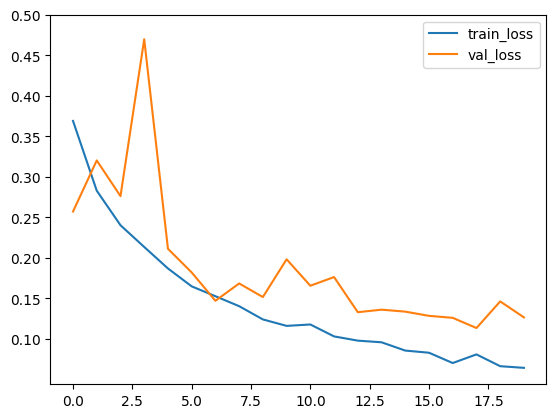

In [11]:
plt.plot(np.arange(config.epoch), train_losses, label='train_loss')
plt.plot(np.arange(config.epoch), validation_losses, label='validation_loss')
plt.legend()
plt.yticks(np.arange(0.01, max(train_losses + validation_losses) + 0.05, 0.05))
plt.show()

#### Resnet50

In [12]:
from torchvision.models import ResNet50_Weights

config = Config(lr=1e-4, epoch=20, dropout=0.2, weight_decay=5e-3)

train_dataloader, validation_dataloader, test_dataloader = get_dataloaders(
    train_dataset, validation_dataset, test_dataset
)

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights=ResNet50_Weights)

for param in model.parameters():
    param.requires_grad = False

for name, param in model.named_parameters():
    if 'layer4' in name or 'fc' in name:
        param.requires_grad = True

model.fc = torch.nn.Sequential(
    torch.nn.Dropout(config.dropout),
    torch.nn.Linear(model.fc.in_features, 2)
)

model = model.to(config.device)

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                              lr=config.lr,
                              weight_decay=config.weight_decay
                              )


model_resnet50, train_losses, validation_losses = train_model(model,
                                                              config,
                                                              optimizer,
                                                              train_dataloader,
                                                              validation_dataloader)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 177MB/s]


Global Progress:   0%|          | 0/20 [00:00<?, ?it/s]

17:44:35 - Best model found at epoch 0
17:44:35 -  Epoch 1/20 - Train Loss: 0.3895 - Val Loss: 0.3247
17:45:13 - Best model found at epoch 1
17:45:13 -  Epoch 2/20 - Train Loss: 0.3239 - Val Loss: 0.3004
17:45:51 - Best model found at epoch 2
17:45:51 -  Epoch 3/20 - Train Loss: 0.3049 - Val Loss: 0.2756
17:46:29 - Best model found at epoch 3
17:46:29 -  Epoch 4/20 - Train Loss: 0.2793 - Val Loss: 0.2447
17:47:08 -  Epoch 5/20 - Train Loss: 0.2601 - Val Loss: 0.2453
17:47:46 - Best model found at epoch 5
17:47:46 -  Epoch 6/20 - Train Loss: 0.2412 - Val Loss: 0.2348
17:48:24 - Best model found at epoch 6
17:48:24 -  Epoch 7/20 - Train Loss: 0.2360 - Val Loss: 0.2226
17:49:02 -  Epoch 8/20 - Train Loss: 0.2283 - Val Loss: 0.2568
17:49:40 - Best model found at epoch 8
17:49:40 -  Epoch 9/20 - Train Loss: 0.2163 - Val Loss: 0.2111
17:50:18 -  Epoch 10/20 - Train Loss: 0.2100 - Val Loss: 0.2201
17:50:56 - Best model found at epoch 10
17:50:56 -  Epoch 11/20 - Train Loss: 0.2010 - Val Loss:

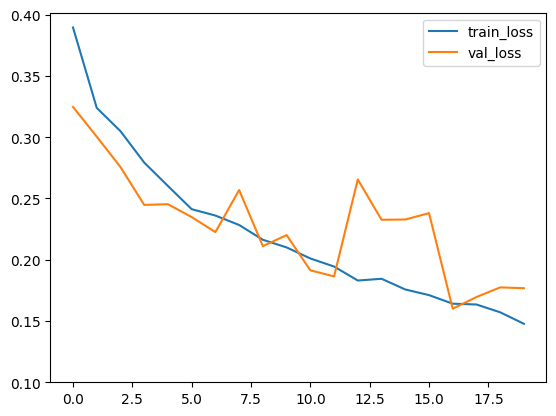

In [13]:
plt.plot(np.arange(len(train_losses)), train_losses, label='train_loss')
plt.plot(np.arange(len(train_losses)), validation_losses, label='validation_loss')
plt.legend()
plt.yticks(np.arange(0.01, max(train_losses + validation_losses) + 0.05, 0.05))
plt.show()

In [14]:
!pip install -q torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 68.4 MB/s eta 0:00:00


------------------------------
Accuracy : 0.9316
Recall   : 0.9566 (Sensibilité)
Precision: 0.9421
F1 Score : 0.9493
------------------------------


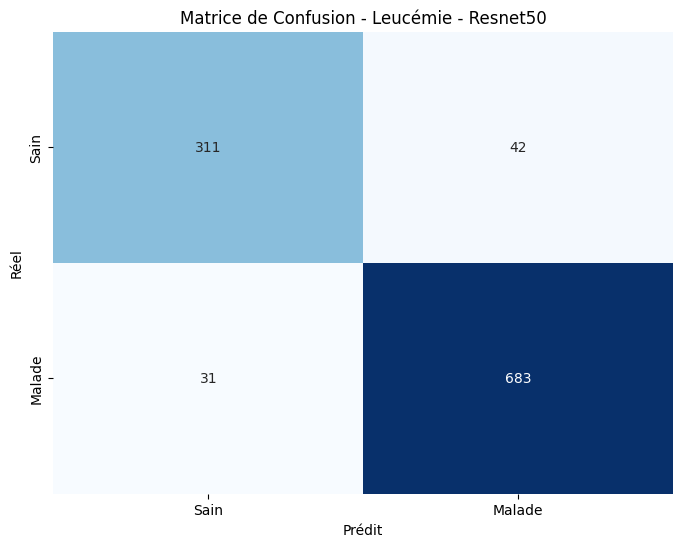

In [15]:
import seaborn as sns
from torchmetrics.classification import BinaryAccuracy, BinaryRecall, BinaryPrecision, BinaryF1Score, BinaryConfusionMatrix

def test_model(model, dataloader, device):
    model.eval()

    # 1. Initialisation des métriques (envoyées sur le GPU/CPU)
    acc_metric = BinaryAccuracy().to(device)
    rec_metric = BinaryRecall().to(device)
    prec_metric = BinaryPrecision().to(device)
    f1_metric = BinaryF1Score().to(device)
    confmat_metric = BinaryConfusionMatrix().to(device)

    with torch.no_grad():
        for image_tensor, label in dataloader:
            img_tensor = image_tensor.to(device)
            label = label.to(device)

            logits = model(img_tensor) # Forme: [Batch, 2]
            probs = torch.softmax(logits, dim=1)[:, 1]

            acc_metric.update(probs, label)
            rec_metric.update(probs, label)
            prec_metric.update(probs, label)
            f1_metric.update(probs, label)
            confmat_metric.update(probs, label)

    final_acc = acc_metric.compute()
    final_rec = rec_metric.compute()
    final_prec = prec_metric.compute()
    final_f1 = f1_metric.compute()
    conf_matrix = confmat_metric.compute()

    print("-" * 30)
    print(f"Accuracy : {final_acc:.4f}")
    print(f"Recall   : {final_rec:.4f} (Sensibilité)")
    print(f"Precision: {final_prec:.4f}")
    print(f"F1 Score : {final_f1:.4f}")
    print("-" * 30)

    acc_metric.reset()
    rec_metric.reset()
    prec_metric.reset()
    f1_metric.reset()
    confmat_metric.reset()

    return conf_matrix

def plot_confusion_matrix(conf_matrix, model_name):
    cm_np = conf_matrix.cpu().numpy()

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_np, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Sain', 'Malade'],
                yticklabels=['Sain', 'Malade'])
    plt.xlabel('Prédit')
    plt.ylabel('Réel')
    plt.title(f'Matrice de Confusion - Leucémie - {model_name}')
    plt.show()


conf_matrix = test_model(model, test_dataloader, config.device)

plot_confusion_matrix(conf_matrix, 'Resnet50')

------------------------------
Accuracy : 0.9653
Recall   : 0.9860 (Sensibilité)
Precision: 0.9631
F1 Score : 0.9744
------------------------------


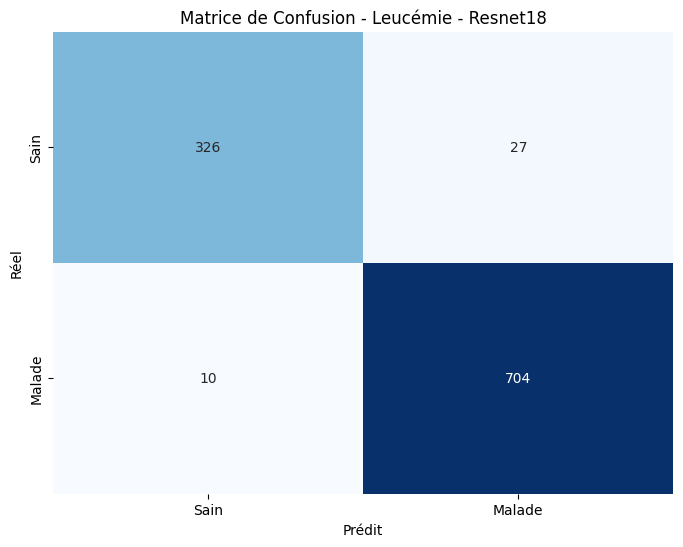

In [16]:
conf_matrix = test_model(model_resnet18, test_dataloader, config.device)

plot_confusion_matrix(conf_matrix, 'Resnet18')